# kNN

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
from clickhouse_driver import Client


user_name = 'user'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to load the data.**

In [3]:
query = '''
SELECT 
  la.*, 
  up.user_type_cars_name
FROM 
  live_adverts as la
LEFT JOIN 
  user_passports AS up ON la.user_id= up.global_id
WHERE 
  la.created_at::Date = '2023-01-30'
'''

In [4]:
result = client.execute(query)

In [5]:
len(result)

36043

In [6]:
df = pd.DataFrame(result, 
                  columns=['execution_date', 'advert_id', 'created_at',
                           'price', 'region', 'user_id', 'platform',
                           'auto_brand', 'auto_model', 'passport_id',
                           'year', 'user_type', 'user_type_cars_name'])

df.head()

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,user_type,user_type_cars_name
0,2023-01-30,271540910,2023-01-30 00:00:02,414000,Самара,134142241,ios,ЗАЗ,Chance,131631637,2014,0,cars_simple
1,2023-01-30,271540911,2023-01-30 00:00:17,620000,Сочи,151328585,ios,Chevrolet,Cruze,144703780,2010,0,cars_simple
2,2023-01-30,271540913,2023-01-30 00:01:21,4970000,Москва,123929189,android,Toyota,Land Cruiser,123950184,2013,6,cars_seller
3,2023-01-30,271540914,2023-01-30 00:04:42,800000,Москва,137723514,android,Subaru,Impreza,134075141,2006,0,cars_simple
4,2023-01-30,271540915,2023-01-30 00:04:57,280000,Пермь,142310446,android,Mitsubishi,RVR,137387157,1995,0,cars_simple


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36043 entries, 0 to 36042
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   execution_date       36043 non-null  object        
 1   advert_id            36043 non-null  int64         
 2   created_at           36043 non-null  datetime64[ns]
 3   price                36043 non-null  int64         
 4   region               36043 non-null  object        
 5   user_id              36043 non-null  int64         
 6   platform             36043 non-null  object        
 7   auto_brand           36043 non-null  object        
 8   auto_model           36043 non-null  object        
 9   passport_id          36043 non-null  int64         
 10  year                 36043 non-null  object        
 11  user_type            36043 non-null  int64         
 12  user_type_cars_name  36043 non-null  object        
dtypes: datetime64[ns](1), int64(5),

In [8]:
df['execution_date'] = pd.to_datetime(df['execution_date'], format='%Y-%m-%d')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36043 entries, 0 to 36042
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   execution_date       36043 non-null  datetime64[ns]
 1   advert_id            36043 non-null  int64         
 2   created_at           36043 non-null  datetime64[ns]
 3   price                36043 non-null  int64         
 4   region               36043 non-null  object        
 5   user_id              36043 non-null  int64         
 6   platform             36043 non-null  object        
 7   auto_brand           36043 non-null  object        
 8   auto_model           36043 non-null  object        
 9   passport_id          36043 non-null  int64         
 10  year                 36043 non-null  object        
 11  user_type            36043 non-null  int64         
 12  user_type_cars_name  36043 non-null  object        
dtypes: datetime64[ns](2), int64(5),

In [10]:
df = df.sort_values(['execution_date', 'user_id', 'advert_id']).reset_index(drop=True)

In [11]:
df.head()

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,user_type,user_type_cars_name
0,2023-01-30,271543213,2023-01-30 03:23:57,0,Москва,123456856,desktop,Unknown,Unknown model,123463122,0,6,cars_seller
1,2023-01-30,271550853,2023-01-30 06:01:54,5000,Москва,123456939,android,Unknown,Unknown model,123463231,0,0,cars_simple
2,2023-01-30,271551604,2023-01-30 06:15:20,7600,Москва,123456939,android,Mitsubishi,Pajero,123463231,0,0,cars_simple
3,2023-01-30,271541982,2023-01-30 02:34:51,900000,Санкт-Петербург,123457280,android,Mitsubishi,Pajero,123463669,2001,0,cars_simple
4,2023-01-30,271550861,2023-01-30 06:02:01,20000,Санкт-Петербург,123457685,ios,BMW,320,123464208,0,0,cars_simple


### Task 2. 

**What is datatype for `year` column? Should we change it?**

In [12]:
df.year.dtype

dtype('O')

In [13]:
df['year'] = df.year.astype('int')

In [14]:
df.year.dtype

dtype('int64')

### Task 3.  

**What is the minimum year of manufacture for a car in our dataset? In your opinion, is this value adequate? Let's delete all rows with this year value.** 

In [15]:
df.year.min()

0

In [16]:
df.year.value_counts()

0       2763
2007    1681
2013    1649
2014    1494
2022    1431
        ... 
1970       2
1972       2
1959       2
1976       1
1969       1
Name: year, Length: 63, dtype: int64

In [17]:
df = df[df['year'] != 0]

In [18]:
df.reset_index(drop=True, inplace=True)

In [19]:
df.head()

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,user_type,user_type_cars_name
0,2023-01-30,271541982,2023-01-30 02:34:51,900000,Санкт-Петербург,123457280,android,Mitsubishi,Pajero,123463669,2001,0,cars_simple
1,2023-01-30,271543912,2023-01-30 03:44:51,1220000,Москва,123458053,ios,BMW,X5,123464695,2005,0,cars_simple
2,2023-01-30,271576473,2023-01-30 14:04:52,500000,Новосибирск,123458440,android,Toyota,Land Cruiser Prado,123465200,1998,0,cars_simple
3,2023-01-30,271554458,2023-01-30 07:06:09,2600000,Москва,123458579,ios,Hyundai,i30,123465390,2022,6,cars_seller
4,2023-01-30,271576237,2023-01-30 13:59:51,1060000,Москва,123458626,ios,Nissan,Patrol,123465453,1998,0,cars_simple


In [20]:
df.year.min()

1950

### Task 4. 

**Which columns will we definitely not be able to use as features when building a model, due to the fact that the values are either unique or the same for all objects?**  

To reproduce the results, before deleting these columns, sort the dataframe by [`'execution_date'`, `'advert_id'`].

In [21]:
df.sort_values(['execution_date', 'advert_id'], inplace = True)

In [22]:
data = df.drop(['execution_date', 'passport_id',
                'advert_id', 'user_id', 'created_at'], axis=1)

In [23]:
data

,price,region,platform,auto_brand,auto_model,year,user_type,user_type_cars_name
3020,414000,Самара,ios,ЗАЗ,Chance,2014,0,cars_simple
15186,620000,Сочи,ios,Chevrolet,Cruze,2010,0,cars_simple
765,4970000,Москва,android,Toyota,Land Cruiser,2013,6,cars_seller
6037,800000,Москва,android,Subaru,Impreza,2006,0,cars_simple
8871,280000,Пермь,android,Mitsubishi,RVR,1995,0,cars_simple
...,...,...,...,...,...,...,...,...
23219,10000,Новосибирск,android,Unknown,Unknown model,2007,0,cars_simple
19978,480000,Новосибирск,ios,ВАЗ (Lada),Priora 2170 (седан),2012,0,cars_simple
24519,1320000,Новосибирск,android,Chevrolet,Cobalt,2021,0,cars_simple
30563,740000,Москва,desktop,Mercedes-Benz,C 320,2002,0,cars_simple


### Task 5. 

**One of the remaining categorical features contains a large number of unique values, which will lead to a too sparse dataset when applying one-hot encoding and will only worsen the quality of the model. Therefore, it needs to be removed.**

In [24]:
cols = data.select_dtypes(['object']).columns

In [25]:
max_cnt = 0
max_str = ''

for col in cols:
    uniq_cnt = data[col].nunique()
    print(f'Column name {col.upper()} --> unique values: {uniq_cnt:.0f}')
    
    if uniq_cnt > max_cnt:
        max_cnt = uniq_cnt
        max_str = col

print(f'\nA column with maximum unique values: {max_str.upper()}')

Column name REGION --> unique values: 21
Column name PLATFORM --> unique values: 4
Column name AUTO_BRAND --> unique values: 85
Column name AUTO_MODEL --> unique values: 829
Column name USER_TYPE_CARS_NAME --> unique values: 4

A column with maximum unique values: AUTO_MODEL


In [26]:
data = data.drop(['auto_model'], axis=1)

In [27]:
data.head()

,price,region,platform,auto_brand,year,user_type,user_type_cars_name
3020,414000,Самара,ios,ЗАЗ,2014,0,cars_simple
15186,620000,Сочи,ios,Chevrolet,2010,0,cars_simple
765,4970000,Москва,android,Toyota,2013,6,cars_seller
6037,800000,Москва,android,Subaru,2006,0,cars_simple
8871,280000,Пермь,android,Mitsubishi,1995,0,cars_simple


### Task 6. 

**There is one more column that is excessive and won't bring any additional value to our model. Delete it as well.**

In [28]:
data = data.drop(['user_type'], axis=1)

In [29]:
data.head()

,price,region,platform,auto_brand,year,user_type_cars_name
3020,414000,Самара,ios,ЗАЗ,2014,cars_simple
15186,620000,Сочи,ios,Chevrolet,2010,cars_simple
765,4970000,Москва,android,Toyota,2013,cars_seller
6037,800000,Москва,android,Subaru,2006,cars_simple
8871,280000,Пермь,android,Mitsubishi,1995,cars_simple


### Task 7. 

**Let's try to make the distribution more symmetric by removing outliers. Let's assume that a car price less than 1000 is an abnormally low value.**

In [30]:
data.price.describe()

count    3.328000e+04
mean     1.124018e+06
std      2.088349e+06
min      0.000000e+00
25%      2.700000e+05
50%      5.600000e+05
75%      1.260000e+06
max      1.333333e+08
Name: price, dtype: float64

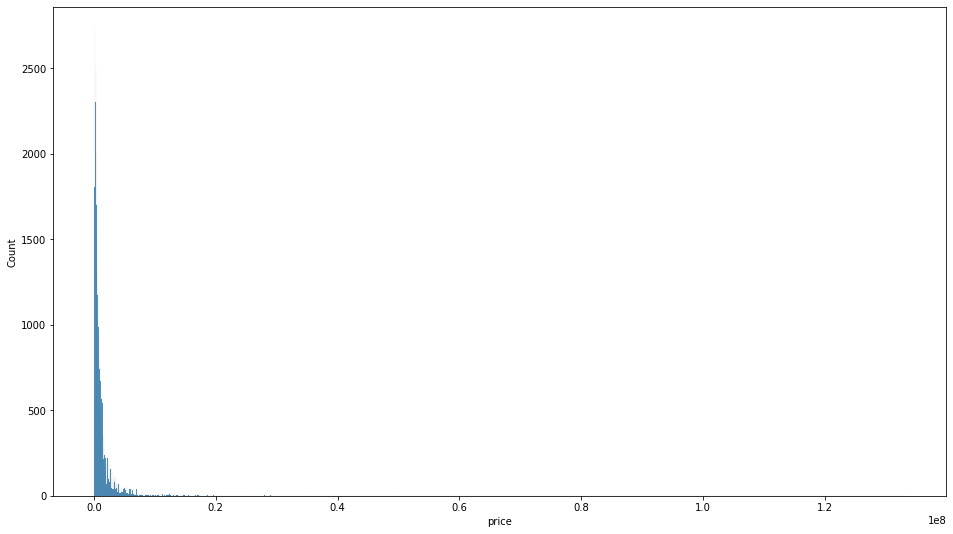

In [31]:
plt.figure(figsize=(16, 9))
sns.histplot(data.price);

In [32]:
data = data[data['price'] > 1000]

In [33]:
data.price.describe()

count    3.307000e+04
mean     1.131156e+06
std      2.093042e+06
min      1.300000e+03
25%      2.800000e+05
50%      5.700000e+05
75%      1.260000e+06
max      1.333333e+08
Name: price, dtype: float64

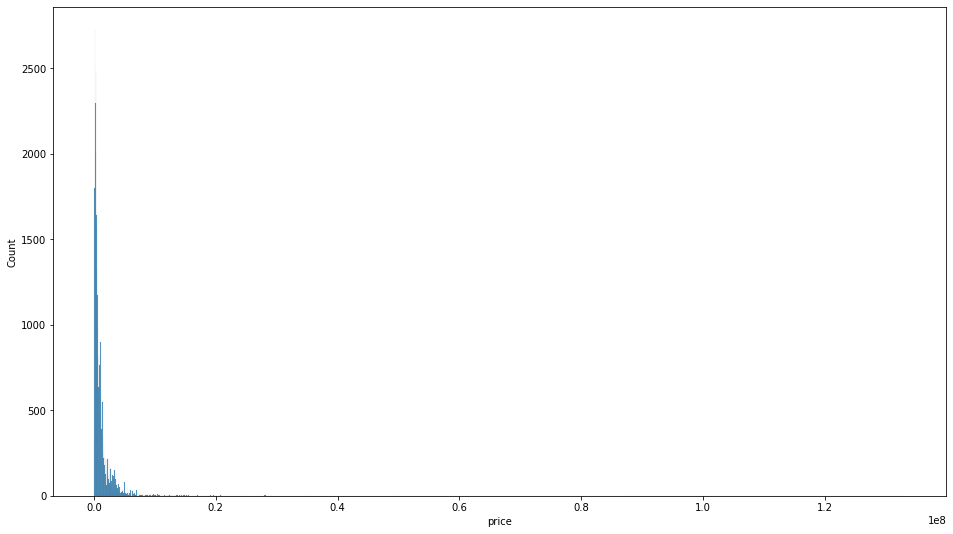

In [34]:
plt.figure(figsize=(16, 9))
sns.histplot(data.price);

### Task 8. 

**Let's log-transform `price` feature.**

In [35]:
data['log_price']= np.log(data['price']) 

In [36]:
data.log_price.describe()

count    33070.000000
mean        13.302673
std          1.108921
min          7.170120
25%         12.542545
50%         13.253392
75%         14.046622
max         18.708363
Name: log_price, dtype: float64

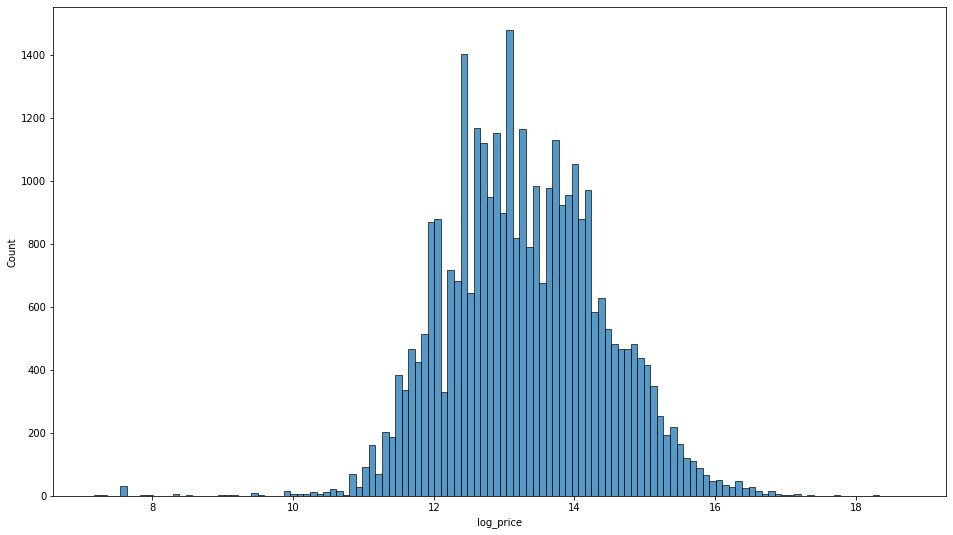

In [37]:
plt.figure(figsize=(16, 9))
sns.histplot(data.log_price);

By applying the logarithm function to the target, we can achieve a distribution that is close to normal. This is a valid action, since logarithmization is a monotonic transformation, i.e. we simply translate our target to another scale - logarithmic.

### Task 9. 

**We will divide the features into categorical and numerical, and define X and y. The target y will be the logarithm of the price. Then we have to split data to train and test samples.**

In [38]:
data

,price,region,platform,auto_brand,year,user_type_cars_name,log_price
3020,414000,Самара,ios,ЗАЗ,2014,cars_simple,12.933621
15186,620000,Сочи,ios,Chevrolet,2010,cars_simple,13.337475
765,4970000,Москва,android,Toyota,2013,cars_seller,15.418930
6037,800000,Москва,android,Subaru,2006,cars_simple,13.592367
8871,280000,Пермь,android,Mitsubishi,1995,cars_simple,12.542545
...,...,...,...,...,...,...,...
23219,10000,Новосибирск,android,Unknown,2007,cars_simple,9.210340
19978,480000,Новосибирск,ios,ВАЗ (Lada),2012,cars_simple,13.081541
24519,1320000,Новосибирск,android,Chevrolet,2021,cars_simple,14.093142
30563,740000,Москва,desktop,Mercedes-Benz,2002,cars_simple,13.514405


In [39]:
X_ = data.drop(['price', 'log_price'], axis=1)
y_ = data['log_price']


X_train, X_test, y_train, y_test = train_test_split(
    X_,
    y_,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((26456, 5), (6614, 5))

### Task 10. 

**Let's use OHE for categorical features and StandardScaler for numerical features. Create a custom ColumnTransformer that will perform all required data transformation.**

In [40]:
col_transformer_with_selector = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), selector(dtype_exclude="number")),             
        ('StandardScaler', StandardScaler(), selector(dtype_include="number"))
    ],
    remainder='passthrough',          
    verbose_feature_names_out=False   
).set_output(transform='pandas')      

In [41]:
final_process_pipeline = Pipeline(
    [
        ('col_transformer', col_transformer_with_selector)
    ]
)

In [42]:
final_process_pipeline.fit_transform(X_train, y_train).head()

,region_Воронеж,region_Екатеринбург,region_Ижевск,region_Казань,region_Калининград,region_Краснодар,region_Красноярск,region_Москва,region_Нижний Новгород,region_Новосибирск,...,auto_brand_ИЖ,auto_brand_ЛуАЗ,auto_brand_Москвич,auto_brand_Ретро-автомобили,auto_brand_ТагАЗ,auto_brand_УАЗ,user_type_cars_name_cars_dealer,user_type_cars_name_cars_seller,user_type_cars_name_cars_simple,year
13887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.080897
14977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.180276
1866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.180276
12173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.080897
1454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.211026


### Task 11. 

**Create a pipeline with CoulumnTransformer and KNeighborsRegressor with default parameters. Set n_jobs=1. What will be r2_score?**

In [43]:
knn_pipeline = Pipeline(
    [
        ('all_preprocess', final_process_pipeline),
        ('simple_model', KNeighborsRegressor(n_jobs=1))
    ]
)

In [44]:
knn_pipeline.fit(X_train, y_train)
knn_pipeline.predict(X_test.head())

array([10.98221306, 12.09496034, 14.41105413, 13.25705606, 13.76214062])

In [45]:
predictions = knn_pipeline.predict(X_test)

In [46]:
r2 = r2_score(y_test, predictions)

print(f'R-squared score: {r2:.2f}')

R-squared score: 0.72


### Task 12. 

**What will be MAE?**

In [47]:
mae = mean_absolute_error(y_test, predictions)

print(f'MAE: {mae:.2f}')

MAE: 0.39


### Task 13.

**Let's use r2_score metric and select hyperparameters for the model using the GridSearchCV.**

In [48]:
knn_grid = {
    'simple_model__n_neighbors': np.linspace(1, 30, 5, dtype=int),
    'simple_model__weights': ['uniform', 'distance'],
    'simple_model__p': [1, 2]
}

In [49]:
print('Searching for the best KNN parameters:')
search_knn = GridSearchCV(knn_pipeline, knn_grid, 
                         cv=None, scoring='r2', return_train_score=True)

search_knn.fit(X_train, y_train)                                   
print(f'Best parameter (CV score={search_knn.best_score_:.5f}):')
print(search_knn.best_params_)

Searching for the best KNN parameters:
Best parameter (CV score=0.79443):
{'simple_model__n_neighbors': 30, 'simple_model__p': 2, 'simple_model__weights': 'distance'}


### Task 14. 

**Train the model with the found hyperparameters on the training set. Check the quality on the test set. Compare with what we got without specifying the hyperparameters.**

tbc..

In [50]:
knn_pipeline = Pipeline(
    [
        ('all_preprocess', final_process_pipeline),
        ('simple_model', KNeighborsRegressor(n_jobs=1, n_neighbors=30, weights='distance', p=2))
    ]
)

In [51]:
knn_pipeline.fit(X_train, y_train)
knn_pipeline.predict(X_test.head())

array([10.98221306, 12.04769399, 14.53219049, 13.09297228, 13.57906681])

In [52]:
predictions = knn_pipeline.predict(X_test)

In [53]:
r2_new = r2_score(y_test, predictions)

print(f'R-squared score: {r2_new:.2f}')

R-squared score: 0.81


In [54]:
print(f'We have improved quality of our model by {r2_new/r2-1:.2%}')

We have improved quality of our model by 13.15%
